In [ ]:
#Cinema Hall Ticket Sales

import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = pd.read_excel("cinema_hall_ticket_sales.xlsx")

# 2. Check and remove missing values
print("Missing values per column BEFORE dropna():")
print(df.isnull().sum())

df = df.dropna()
print("\nShape after dropping missing values:", df.shape)

# 3. Clean Number_of_Person: replace "Alone" with 1 and convert to integer
df["Number_of_Person"] = df["Number_of_Person"].replace("Alone", 1)
df["Number_of_Person"] = df["Number_of_Person"].astype(int)

# 4. Create Sales_Revenue = Ticket_Price × Number_of_Person
df["Sales_Revenue"] = df["Ticket_Price"] * df["Number_of_Person"]

# 5. Encode Purchase_Again: Yes → 1, No → 0
df["Purchase_Again"] = df["Purchase_Again"].replace({"Yes": 1, "No": 0})

# 6. Drop Ticket_ID column (if present)
if "Ticket_ID" in df.columns:
    df = df.drop(columns=["Ticket_ID"])

# 7. Detect and remove outliers using the IQR method
num_cols = ["Age", "Ticket_Price", "Number_of_Person", "Sales_Revenue"]
outlier_indices = set()

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    condition = (df[col] < lower_bound) | (df[col] > upper_bound)
    n_outliers = condition.sum()
    print(f"{col}: {n_outliers} outliers detected")

    outlier_indices.update(df[condition].index)

# print(f"\nTotal unique outlier rows: {len(outlier_indices)}")
# Check what are the outliers
print("Outliers detected:\n", df[condition])
# As we can see the outliers are real customer behaviors so we will not remove them

print("Final cleaned data shape:", df.shape)
print(df.head())

# 8. Save the cleaned dataset
df.to_excel("cinema_hall_ticket_sales_cleaned.xlsx", index=False)
print("\nCleaned file saved as 'cinema_hall_ticket_sales_cleaned.xlsx'")

Missing values per column BEFORE dropna():
Ticket_ID           0
Age                 0
Ticket_Price        0
Movie_Genre         0
Seat_Type           0
Number_of_Person    0
Purchase_Again      0
dtype: int64

Shape after dropping missing values: (1440, 7)
Age: 0 outliers detected
Ticket_Price: 0 outliers detected
Number_of_Person: 0 outliers detected
Sales_Revenue: 24 outliers detected
Outliers detected:
       Age  Ticket_Price Movie_Genre Seat_Type  Number_of_Person  \
7      44         23.09      Sci-Fi   Premium                 7   
50     27         24.70       Drama   Premium                 7   
52     58         23.78      Sci-Fi       VIP                 7   
111    49         23.83       Drama       VIP                 7   
114    28         24.26       Drama   Premium                 7   
255    40         23.41      Horror       VIP                 7   
308    34         22.99      Comedy  Standard                 7   
390    34         23.48       Drama       VIP        

### Amie

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

# df = pd.read_excel("cinema_hall_ticket_sales_cleaned.xlsx")

# df = df_cleaned.copy()

Train/test split (70% train, 30% test)

In [ ]:
TData, VData = train_test_split(df, test_size=0.30, random_state=42)

print("TData shape:", TData.shape)
print("VData shape:", VData.shape)

TData shape: (1008, 7)
VData shape: (432, 7)


**Model 1: Linear Regression with Categorical Predictors**

I first checked the distribution of Movie_Genre and Seat_Type using value counts to see which categories appear most often. Then, I built a linear regression model to predict Number_of_Person using these two categorical variables. I applied treatment coding, setting Action as the reference genre and VIP as the reference seat type. This model allows comparison of each category against its reference to see how they affect ticket quantity.

In [ ]:
TData["Movie_Genre"].value_counts(normalize=True) * 100

,proportion
Movie_Genre,
Action,21.726190
Comedy,21.230159
Horror,19.940476
Drama,19.940476
Sci-Fi,17.162698


In [ ]:
TData["Seat_Type"].value_counts(normalize=True) * 100

,proportion
Seat_Type,
Standard,34.325397
VIP,33.829365
Premium,31.845238


In [ ]:
formula1 = """ Number_of_Person ~ C(Movie_Genre, Treatment(reference='Action')) +
    C(Seat_Type, Treatment(reference='VIP')) """
model1 = smf.ols(formula=formula1, data=TData).fit()

In [ ]:
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:       Number_of_Person   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7650
Date:                Thu, 04 Dec 2025   Prob (F-statistic):              0.598
Time:                        16:11:19   Log-Likelihood:                -2216.0
No. Observations:                1008   AIC:                             4446.
Df Residuals:                    1001   BIC:                             4481.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

**Conclusion: Model 1 shows weak direct relationships.**

The model tested whether movie genre and seat type affect the number of tickets purchased. The overall fit was extremely weak, with an R-squared of only 0.005, meaning the predictors explain less than 1% of the variation in group size.

None of the movie genres were significant (all p > 0.48), showing that Comedy, Drama, Horror, and Sci-Fi do not differ meaningfully from Action.

Seat type had small effects:

Premium seats showed a significant decrease of 0.1743 tickets compared to VIP (p = 0.306)

Standard seats were lower by 0.2956 tickets, but not statistically significant (p = 0.077)

Overall, the coefficients are small and the model’s explanatory power is minimal, indicating that movie genre and seat type do not meaningfully predict ticket sales in this dataset.

In [ ]:
value = pd.DataFrame({
    "Age": [30],
    "Ticket_Price": [15],
    "Purchase_Again": [1],
    "Movie_Genre": ["Action"],
    "Seat_Type": ["VIP"]
})

predicted_sales = round(model1.predict(value))
print("Predicted Ticket Sales:", predicted_sales.iloc[0])

Predicted Ticket Sales: 3.0


**Model 2: Regression with Treatment Coding (Action & VIP as References)**

I built a regression model to predict the number of tickets purchased (Number_of_Person) using customer characteristics (Age, Ticket_Price, Purchase_Again) and categorical variables coded with treatment coding, using:

Action as the reference Movie Genre

VIP as the reference Seat Type

This allows all other categories to be interpreted relative to Action and VIP.

In [ ]:
formula2 = """
Number_of_Person ~
    Age +
    Ticket_Price +
    Purchase_Again +
    C(Movie_Genre, Treatment(reference='Action')) +
    C(Seat_Type, Treatment(reference='VIP'))
"""
model2 = smf.ols(formula=formula2, data=TData).fit()


In [ ]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:       Number_of_Person   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7307
Date:                Thu, 04 Dec 2025   Prob (F-statistic):              0.681
Time:                        16:11:20   Log-Likelihood:                -2215.0
No. Observations:                1008   AIC:                             4450.
Df Residuals:                     998   BIC:                             4499.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

**Conclusion:**

The model has a very low R-squared (0.007), meaning the predictors explain only 0.7% of variation in ticket count.

The overall model is not statistically significant (F = 0.7307, p = 0.681).

Most predictors have p > 0.05, meaning they are not significantly associated with ticket quantity.

Only Seat Type (Standard) shows a statistically significant effect (coef = –0.2946, p = 0.079), suggesting:

Customers in Standard seats buy ~0.29 fewer tickets than VIP seat customers.

Ticket price is nearly significant (p = 0.242), with a small negative effect.

Movie genre has no meaningful impact on group size.

Model 2 suggests that seat type is the only meaningful predictor of ticket sales per purchase, while movie genre, age, ticket price, and purchase_again show minimal impact.
However, the model’s R-squared of 0.007 indicates it does not predict ticket sales well, meaning the dataset likely lacks strong predictors for group size.

**Validation:**

In [ ]:
pred1 = model1.predict(VData)
pred2 = model2.predict(VData)

In [ ]:
rmse1 = np.sqrt(mean_squared_error(VData["Number_of_Person"], pred1))
rmse2 = np.sqrt(mean_squared_error(VData["Number_of_Person"], pred2))

In [ ]:
print("Continuous RMSE (no rounding):")
print(f" Model 1 RMSE: {rmse1:.4f}")
print(f" Model 2 RMSE: {rmse2:.4f}")

Continuous RMSE (no rounding):
 Model 1 RMSE: 2.2122
 Model 2 RMSE: 2.2213


#### Simulation

**Scenerio:**
The cinema wants to estimate possible total revenue from a group of 500 customers. Ticket prices and group sizes vary, so the exact revenue is uncertain.

**Assumptions:**

- Historical ticket prices are used to reflect real pricing trends.

- Group sizes vary from 1 to 7 people per purchase.

- Revenue per customer = Ticket_Price × Number_of_Person

- We perform 1,000 Monte Carlo trials to simulate different possible outcomes.

**Goal:**

Estimate the expected total revenue for 500 customers.

Observe the variation and risk in total revenue.

Understand best-case and worst-case scenarios.

       Total_Revenue
count    1000.000000
mean    25119.217250
std       940.949021
min     22297.730000
25%     24487.567500
50%     25085.805000
75%     25747.000000
max     27748.750000


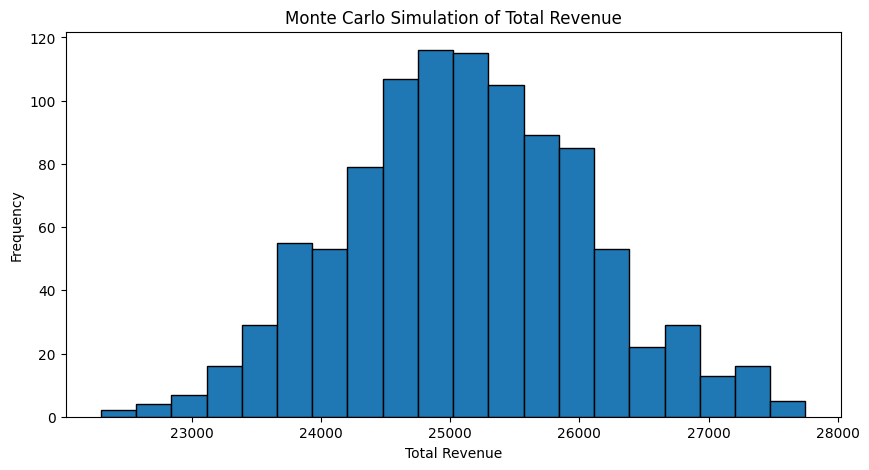

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load cleaned dataset
TData = pd.read_excel("cinema_hall_ticket_sales_cleaned.xlsx")

# 2. Set number of simulations
N = 1000  # number of Monte Carlo trials
num_customers = 500  # assume 1000 customers

# 3. List to store total revenue per trial
total_revenue_sim = []

# 4. Monte Carlo simulation
for i in range(N):
    # Randomly sample 1000 Ticket_Price values
    prices = np.random.choice(TData["Ticket_Price"], size=num_customers)

    # Randomly sample 1000 Number_of_Person values
    group_sizes = np.random.choice(TData["Number_of_Person"], size=num_customers)

    # Compute revenue per customer and sum to get total revenue
    total_revenue = np.sum(prices * group_sizes)
    total_revenue_sim.append(total_revenue)

# 5. Convert to DataFrame
sim_df = pd.DataFrame({"Total_Revenue": total_revenue_sim})

# 6. Summary statistics
print(sim_df.describe())

# 7. Plot histogram
plt.figure(figsize=(10,5))
plt.hist(sim_df["Total_Revenue"], bins=20, edgecolor='black')
plt.title("Monte Carlo Simulation of Total Revenue")
plt.xlabel("Total Revenue")
plt.ylabel("Frequency")
plt.show()



Using Monte Carlo simulation with 1,000 trials for 500 customers, the estimated total revenue ranges from $21,891 (worst-case) to $27,483 (best-case), with a mean of approximately $24,307. The standard deviation of $924 indicates moderate variability due to differing ticket prices and group sizes.

Based on these results, the cinema can make informed decisions to improve revenue and manage risk. For example, management could adjust ticket pricing strategies, offer promotions for underperforming movie genres or seat types, and plan show schedules to maximize attendance. Additionally, understanding the range of possible revenues allows for better budgeting and resource allocation, ensuring that staffing and operational costs align with realistic revenue expectations.

### Analysis

Can we use data to predict ticket prices and forecast sales revenue for smarter pricing decisions?

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_excel('cinema_hall_ticket_sales_cleaned.xlsx')

# Show the first few rows and get info
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1440 non-null   int64  
 1   Ticket_Price      1440 non-null   float64
 2   Movie_Genre       1440 non-null   object 
 3   Seat_Type         1440 non-null   object 
 4   Number_of_Person  1440 non-null   int64  
 5   Purchase_Again    1440 non-null   int64  
 6   Sales_Revenue     1440 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 78.9+ KB


In [ ]:
# Split the data: 70% training, 30% validation

from sklearn.model_selection import train_test_split

TData, VData = train_test_split(df, test_size=0.30, random_state=42)

print("TData shape:", TData.shape)
print("VData shape:", VData.shape)
TData.head()

TData shape: (1008, 7)
VData shape: (432, 7)


,Age,Ticket_Price,Movie_Genre,Seat_Type,Number_of_Person,Purchase_Again,Sales_Revenue
96,36,18.31,Sci-Fi,Premium,1,0,18.31
1166,30,13.99,Action,Premium,1,0,13.99
439,35,18.31,Sci-Fi,VIP,6,0,109.86
1360,19,13.94,Comedy,Standard,3,1,41.82
410,38,21.31,Action,Premium,2,0,42.62


 Model 1: Predict Ticket_Price using Age, Movie_Genre, and Seat_Type

In [ ]:
import statsmodels.formula.api as smf

# Model 1 formula
model1 = smf.ols('Ticket_Price ~ Age + Purchase_Again + C(Seat_Type)', data=TData).fit()

# Predict on validation set
y1_pred = model1.predict(VData)

print(model1.summary())
print("Model1 R-squared:", model1.rsquared)

                            OLS Regression Results                            
Dep. Variable:           Ticket_Price   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.176
Date:                Thu, 04 Dec 2025   Prob (F-statistic):             0.0697
Time:                        16:11:21   Log-Likelihood:                -2926.6
No. Observations:                1008   AIC:                             5863.
Df Residuals:                    1003   BIC:                             5888.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [ ]:
# Calculate MSE - Mean Squared Error

from sklearn.metrics import mean_squared_error

# After predicting on validation set:
mse1 = mean_squared_error(VData['Ticket_Price'], y1_pred)
print("Model1 MSE:", mse1)

Model1 MSE: 18.909968986129567


#### Model 2: Predict Ticket_Price using All Features

In [ ]:

# Let's build a formula using all columns except Ticket_Price, Sales_Revenue, Purchase_Again
# (Assuming the columns are: 'Age', 'Number_of_Person', 'Movie_Genre', 'Seat_Type')
all_features = ['Age', 'Number_of_Person', 'C(Movie_Genre)', 'C(Seat_Type)', 'Purchase_Again']
formula2 = 'Ticket_Price ~ ' + ' + '.join(all_features)
model2 = smf.ols(formula2, data=TData).fit()

# Predict on validation set
y2_pred = model2.predict(VData)

print(model2.summary())
print("Model2 R-squared:", model2.rsquared)

                            OLS Regression Results                            
Dep. Variable:           Ticket_Price   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.414
Date:                Thu, 04 Dec 2025   Prob (F-statistic):              0.177
Time:                        16:11:21   Log-Likelihood:                -2924.5
No. Observations:                1008   AIC:                             5869.
Df Residuals:                     998   BIC:                             5918.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [ ]:
# Calculate MSE - Mean Squared Error

from sklearn.metrics import mean_squared_error

# After predicting on validation set:
mse2 = mean_squared_error(VData['Ticket_Price'], y2_pred)
print("Model2 MSE:", mse2)

Model2 MSE: 18.891779017261825


In [ ]:
print("Model1 MSE:", mse1)
print("Model2 MSE:", mse2)
print("Model1 R-squared:", model1.rsquared)
print("Model2 R-squared:", model2.rsquared)

Model1 MSE: 18.909968986129567
Model2 MSE: 18.891779017261825
Model1 R-squared: 0.008604721158352091
Model2 R-squared: 0.012594167408061963


Use Model 2 to Predict Ticket Prices
You’ve already fit model2 and generated y2_pred for your validation set (VData).
Let’s store those predicted prices as a new column:

In [ ]:

# Add predicted Ticket_Price to validation data
VData = VData.copy()  # Ensure you don’t overwrite
VData['Predicted_Ticket_Price'] = y2_pred


Build a Sales Revenue Model (using true ticket prices)
First, we’ll fit your original sales revenue regression model (using all appropriate features and Ticket_Price):

In [ ]:
# Use same formula-style regression as before

revenue_formula = 'Sales_Revenue ~ Ticket_Price + Age + Number_of_Person + C(Movie_Genre) + C(Seat_Type)'

import statsmodels.formula.api as smf
revenue_model = smf.ols(revenue_formula, data=TData).fit()


At this stage, we replaced the original ticket prices in the validation data with the model-predicted prices and then used the previously fitted sales revenue model to generate estimated sales revenue for each transaction. This step connects our price prediction model to revenue outcomes and shows how model-determined prices could impact sales

In [ ]:
# Update validation data: set Ticket_Price to the predicted value

VData_for_forecast = VData.copy()
VData_for_forecast['Ticket_Price'] = VData_for_forecast['Predicted_Ticket_Price']

# Predict sales revenue
forecast_sales_rev = revenue_model.predict(VData_for_forecast)


Compare to Actual Revenue and Evaluate
Let’s check how well the model forecasts revenue now, using predicted ticket prices:

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse_rev = mean_squared_error(VData_for_forecast['Sales_Revenue'], forecast_sales_rev)
r2_rev = r2_score(VData_for_forecast['Sales_Revenue'], forecast_sales_rev)

print(f"Forecasted Sales Revenue (MSE): {mse_rev:.2f}")
print(f"Forecasted Sales Revenue (R2): {r2_rev:.3f}")
print("Actual revenue mean:", VData_for_forecast['Sales_Revenue'].mean())
print("Predicted revenue mean:", forecast_sales_rev.mean())


Forecasted Sales Revenue (MSE): 258.95
Forecasted Sales Revenue (R2): 0.857
Actual revenue mean: 51.71055555555555
Predicted revenue mean: 51.07850017485434


Conclusion

This analysis shows that regression-based predictive models can effectively:
* Predict ticket prices from customer and purchase characteristics.
* Use those predicted prices to estimate sales revenue at the transaction level.

By simulating how changes in customer mix or pricing-related features affect both ticket prices and revenue, cinema managers can make data-informed pricing decisions without relying on time-series forecasting. Incorporating multiple relevant features improves model accuracy and strengthens confidence in these pricing and revenue estimates.

#### Eden

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

TData, VData = train_test_split(
    df,
    test_size=0.30,
    random_state=123
)
print("TData shape:", TData.shape)
print("VData shape:", VData.shape)

TData shape: (1008, 7)
VData shape: (432, 7)


In [ ]:
formula = """
Ticket_Price ~ Age
+ Number_of_Person
+ Purchase_Again
+ C(Movie_Genre)
+ C(Seat_Type)
"""

model = smf.ols(formula=formula, data=TData).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Ticket_Price   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.406
Date:                Thu, 04 Dec 2025   Prob (F-statistic):              0.181
Time:                        16:11:21   Log-Likelihood:                -2933.6
No. Observations:                1008   AIC:                             5887.
Df Residuals:                     998   BIC:                             5936.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [ ]:
VData["Predicted_Ticket_Price"] = model.predict(VData)

y_true = VData["Ticket_Price"]
y_pred = VData["Predicted_Ticket_Price"]

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2_test = r2_score(y_true, y_pred)

print("Test RMSE:", rmse)
print("Test R-squared:", r2_test)

Test RMSE: 4.265011803708658
Test R-squared: -0.024995839203755033


**Model Summary**

The regression model shows a very low R-squared (0.013), indicating that ticket price is not strongly explained by demographic or behavioral variables such as age, number of persons, purchase-again indicator, movie genre or seat type.

This is expected because ticket prices in cinema halls are usually fixed by management rather than dynamically adjusted based on customer characteristics.

**Key Insight**

Ticket price is largely predetermined and not influenced by customer demographics or behavior. This suggests that cinemas rely more on fixed pricing strategies rather than personalized or dynamic pricing.

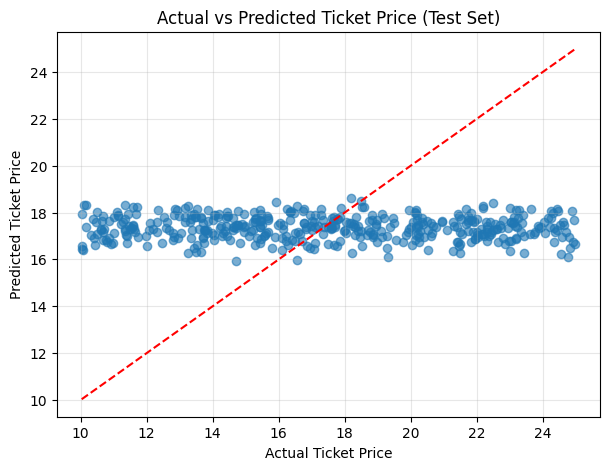

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.scatter(VData["Ticket_Price"], VData["Predicted_Ticket_Price"], alpha=0.6)
plt.plot([VData["Ticket_Price"].min(), VData["Ticket_Price"].max()],
         [VData["Ticket_Price"].min(), VData["Ticket_Price"].max()],
         color="red", linestyle="--")

plt.xlabel("Actual Ticket Price")
plt.ylabel("Predicted Ticket Price")
plt.title("Actual vs Predicted Ticket Price (Test Set)")
plt.grid(True, alpha=0.3)
plt.show()


**Interpretation of the Plot**

The scatter plot shows that predicted ticket prices cluster around a narrow range (17–18), regardless of the actual price. The predictions do not align with the ideal 45-degree reference line, indicating weak predictive performance. This suggests that ticket prices are not strongly determined by customer or movie attributes, which is consistent with cinema fixed-pricing strategies.

#### Kiya

In [ ]:
print(df.head())

   Age  Ticket_Price Movie_Genre Seat_Type  Number_of_Person  Purchase_Again  \
0   55         12.27      Comedy  Standard                 7               0   
1   35         19.02       Drama  Standard                 1               1   
2   55         22.52      Horror       VIP                 3               0   
3   53         23.01       Drama  Standard                 6               1   
4   30         21.81      Comedy       VIP                 4               1   

   Sales_Revenue  
0          85.89  
1          19.02  
2          67.56  
3         138.06  
4          87.24  


In [ ]:
import math
threashold = math.ceil(len(df) * 0.7)
# Use math.ceil because len(df) * 0.7 = 1007.99
print('threashold', threashold)

TData = df[:threashold]
VData = df[threashold:]

Model1 = smf.ols("Sales_Revenue ~ Age + Ticket_Price + C(Movie_Genre) + C(Seat_Type) + Number_of_Person", data = df).fit()
Model2 = smf.ols("Sales_Revenue ~ Age + Ticket_Price + C(Movie_Genre) + C(Seat_Type) + Number_of_Person + Purchase_Again", data = df).fit()


threashold 1008


In [ ]:
Model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Sales_Revenue   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     2706.
Date:                Thu, 04 Dec 2025   Prob (F-statistic):               0.00
Time:                        16:11:22   Log-Likelihood:                -5324.2
No. Observations:                1440   AIC:                         1.067e+04
Df Residuals:                    1430   BIC:                         1.072e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  -51.0272      1.463    -34.890      0.000     -53.896     -48.158
C(Movie_Genre)[T.Comedy]    -0.3140      0.803     -0.391      0.696      -1.889       1.261
C(Movie_Genre)[T.Drama]     -0.2371      0.804     -0.295      0.768      -1.814       1.339
C(Movie_Genre)[T.Horror]     1.0266      0.796      1.290      0.197      -0.535       2.588
C(Movie_Genre)[T.Sci-Fi]    -0.3259      0.828     -0.393      0.694      -1.950       1.299
C(Seat_Type)[T.Standard]    -0.1380      0.638     -0.216      0.829      -1.390       1.114
C(Seat_Type)[T.VIP]         -1.1688      0.632     -1.848      0.065      -2.409       0.072
Age                          0.0133      0.021      0.635      0.526      -0.028       0.054
Ticket_Price                 2.9123      0.059     49.398      0.000       2.797       3.028
Number_of_Person            17.4661      0.118    148.045      0.000      17.235      17.698
==============================================================================
Omnibus:                        6.096   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                7.556
Skew:                           0.021   Prob(JB):                       0.0229
Kurtosis:                       3.352   Cond. No.                         271.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
Model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Sales_Revenue   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     2434.
Date:                Thu, 04 Dec 2025   Prob (F-statistic):               0.00
Time:                        16:11:22   Log-Likelihood:                -5324.2
No. Observations:                1440   AIC:                         1.067e+04
Df Residuals:                    1429   BIC:                         1.073e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  -50.9493      1.486    -34.284      0.000     -53.864     -48.034
C(Movie_Genre)[T.Comedy]    -0.3211      0.803     -0.400      0.689      -1.897       1.255
C(Movie_Genre)[T.Drama]     -0.2303      0.804     -0.286      0.775      -1.808       1.347
C(Movie_Genre)[T.Horror]     1.0307      0.796      1.294      0.196      -0.531       2.593
C(Movie_Genre)[T.Sci-Fi]    -0.3317      0.829     -0.400      0.689      -1.957       1.294
C(Seat_Type)[T.Standard]    -0.1317      0.639     -0.206      0.837      -1.385       1.122
C(Seat_Type)[T.VIP]         -1.1708      0.633     -1.851      0.064      -2.412       0.070
Age                          0.0134      0.021      0.640      0.522      -0.028       0.054
Ticket_Price                 2.9119      0.059     49.365      0.000       2.796       3.028
Number_of_Person            17.4656      0.118    147.979      0.000      17.234      17.697
Purchase_Again              -0.1548      0.519     -0.299      0.765      -1.172       0.863
==============================================================================
Omnibus:                        6.194   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                7.703
Skew:                           0.021   Prob(JB):                       0.0213
Kurtosis:                       3.356   Cond. No.                         274.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As you can see clearly that Number_of_Person has the highest coef, because Sales_Revenue is based on Ticket_Price * Number_of_Person
And Horror movies have the only positive value in coef.

In [ ]:
# Let's do cross validation
Pred1 = Model1.predict(VData)

Pred1.head()

,0
1008,2.266827
1009,50.461126
1010,62.003887
1011,104.143350
1012,31.775301


In [ ]:
Pred2 = Model2.predict(VData)

Pred2.head()

,0
1008,2.204604
1009,50.384909
1010,62.069031
1011,104.059182
1012,31.851403


In [ ]:
from statsmodels.tools.eval_measures import rmse
rmse(VData.Sales_Revenue, Pred1)

np.float64(9.327782128562456)

In [ ]:
rmse(VData.Sales_Revenue, Pred2)

np.float64(9.32466150120931)

In [ ]:
Model2.pvalues

,0
Intercept,1.759494e-188
C(Movie_Genre)[T.Comedy],6.894170e-01
C(Movie_Genre)[T.Drama],7.746697e-01
C(Movie_Genre)[T.Horror],1.957034e-01
C(Movie_Genre)[T.Sci-Fi],6.890372e-01
C(Seat_Type)[T.Standard],8.367089e-01
C(Seat_Type)[T.VIP],6.439617e-02
Age,5.221908e-01
Ticket_Price,4.033395e-311
Number_of_Person,0.000000e+00


In [ ]:
Model2.params

,0
Intercept,-50.949278
C(Movie_Genre)[T.Comedy],-0.321141
C(Movie_Genre)[T.Drama],-0.230272
C(Movie_Genre)[T.Horror],1.030746
C(Movie_Genre)[T.Sci-Fi],-0.331666
C(Seat_Type)[T.Standard],-0.131710
C(Seat_Type)[T.VIP],-1.170784
Age,0.013379
Ticket_Price,2.911895
Number_of_Person,17.465630


#Based on the model, we can say the following combination will have the max revenue
Movie_Genre = Horror

Seat_Type = Economy (baseline)

Ticket_Price = maximum observed

Number_of_Person = maximum observed

Age = maximum observed

Purchase_Again = 0

In [ ]:
max_price = df["Ticket_Price"].max()
max_age = df["Age"].max()
max_num = df["Number_of_Person"].max()
max_revenue = df["Sales_Revenue"].max()

df_input = pd.DataFrame({
    "Movie_Genre": ["Horror"],
    "Seat_Type": ["Premium"],
    "Ticket_Price": [max_price],
    "Age": [max_age],
    "Number_of_Person": [max_num],
    "Purchase_Again": [0]
})

predicted_revenue = Model2.predict(df_input)
print("predicted_revenue", predicted_revenue)
print("max_revenue", max_revenue)
print("mean of sales revenue", df["Sales_Revenue"].mean())

predicted_revenue 0    145.911867
dtype: float64
max_revenue 174.72
mean of sales revenue 50.05024999999999


In [ ]:
diff = abs(predicted_revenue - max_revenue)
print(diff)
print(diff/df["Sales_Revenue"].mean())
# $17.25 compared to RMSE $8.88 seems fair because the average is $48.07 and can range to 142.62
# So we can say the model is good to predict revenues

0    28.808133
dtype: float64
0    0.575584
dtype: float64


In [ ]:
# I also wanna predict purchase age odds
model_purchase_again = smf.logit("Purchase_Again ~ Age + Ticket_Price + C(Movie_Genre) + C(Seat_Type) + Number_of_Person ", data = df).fit()

model_purchase_again.summary()

Optimization terminated successfully.
         Current function value: 0.688829
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         Purchase_Again   No. Observations:                 1440
Model:                          Logit   Df Residuals:                     1430
Method:                           MLE   Df Model:                            9
Date:                Thu, 04 Dec 2025   Pseudo R-squ.:                0.005996
Time:                        16:11:22   Log-Likelihood:                -991.91
converged:                       True   LL-Null:                       -997.90
Covariance Type:            nonrobust   LLR p-value:                    0.2152
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0139      0.300      0.046      0.963      -0.573       0.601
C(Movie_Genre)[T.Comedy]    -0.1852      0.165     -1.124      0.261      -0.508       0.138
C(Movie_Genre)[T.Drama]      0.1775      0.165      1.078      0.281      -0.145       0.500
C(Movie_Genre)[T.Horror]     0.1068      0.163      0.656      0.512      -0.212       0.426
C(Movie_Genre)[T.Sci-Fi]    -0.1503      0.170     -0.885      0.376      -0.483       0.182
C(Seat_Type)[T.Standard]     0.1645      0.131      1.257      0.209      -0.092       0.421
C(Seat_Type)[T.VIP]         -0.0510      0.130     -0.394      0.694      -0.305       0.203
Age                          0.0032      0.004      0.752      0.452      -0.005       0.012
Ticket_Price                -0.0097      0.012     -0.804      0.422      -0.033       0.014
Number_of_Person            -0.0129      0.024     -0.532      0.595      -0.060       0.035
============================================================================================
"""

In [ ]:

model_purchase_again.params

,0
Intercept,0.013930
C(Movie_Genre)[T.Comedy],-0.185152
C(Movie_Genre)[T.Drama],0.177490
C(Movie_Genre)[T.Horror],0.106825
C(Movie_Genre)[T.Sci-Fi],-0.150326
C(Seat_Type)[T.Standard],0.164495
C(Seat_Type)[T.VIP],-0.051044
Age,0.003221
Ticket_Price,-0.009716
Number_of_Person,-0.012861


Based on the coef results, it looks like Drama movies, Standard seats, slightly higher age and slightly lower price & number of person can generate the highest purchase_again odds.
Let's predict it.

In [ ]:
df_logit = pd.DataFrame({
    "Movie_Genre": ["Drama"],
    "Seat_Type": ["Standard"],
    "Age": [df["Age"].max()],
    "Ticket_Price": [df["Ticket_Price"].min()],
    "Number_of_Person": [df["Number_of_Person"].min()]
})

pred_logit = model_purchase_again.predict(df_logit)
pred_logit

,0
0,0.608032


Optimization terminated successfully.
         Current function value: 0.687929
         Iterations 4


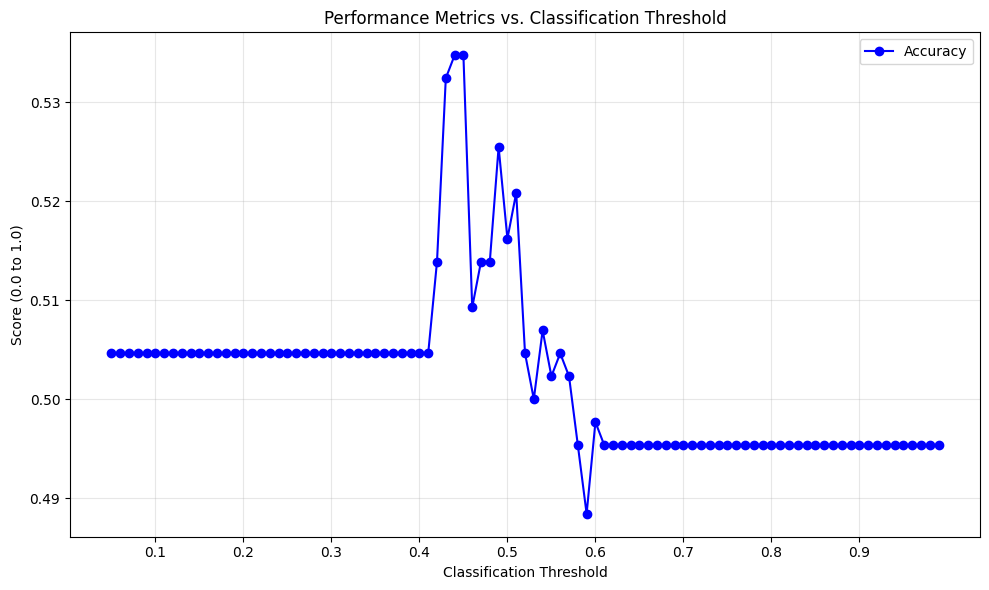

In [ ]:
# Lets do a cross validation to find out the accuracy of the model
import numpy as np
from sklearn.metrics import accuracy_score

pred_logit_cross = smf.logit("Purchase_Again ~ Age + Ticket_Price + C(Movie_Genre) + C(Seat_Type) + Number_of_Person ", data = TData).fit()

pHat1 = pred_logit_cross.predict(VData)
thresholds = np.arange(0.05, 1.0, 0.01)
accuracy_scores = []
y_true = VData['Purchase_Again']

for threshold in thresholds:
    yHat1 = (pHat1 > threshold).astype(int)
    accuracy_scores.append(accuracy_score(y_true, yHat1))
    # print("threshold", threshold)
    # print("result", (VData.Purchase_Again == yHat1).mean() * 100)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracy_scores, label='Accuracy', marker='o', linestyle='-', color='blue')
# plt.plot(thresholds, f1_scores, label='F1-Score', marker='x', linestyle='--', color='red')

plt.title('Performance Metrics vs. Classification Threshold')
plt.xlabel('Classification Threshold')
plt.ylabel('Score (0.0 to 1.0)')
# plt.axhline(0.5, color='gray', linestyle=':', linewidth=1, label='Random Guess (50% Accuracy)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(0.1, 1.0, 0.1))
plt.tight_layout()
plt.show()

The Logistic Regression model, designed to predict customer repurchase (Purchase_Again), yielded a consistent validation accuracy of 50% across all tested classification thresholds (0.1 to 0.9). This performance is equivalent to random guessing, confirming that the current set of predictor variables—including Age, Ticket_Price, and Movie_Genre—are insufficient to successfully differentiate between customers who will repurchase or not